Skipping file with unexpected name or timestamp format: IMG_NO__IMES_AMP.jpg
Timestamp: 2025-09-12 11:31:08+00:00
Latitude: 51.775047, Longitude: -3.95207, Speed: 60.12
Image Path: /content/IMG_2025_09_12_11_31_08.jpg


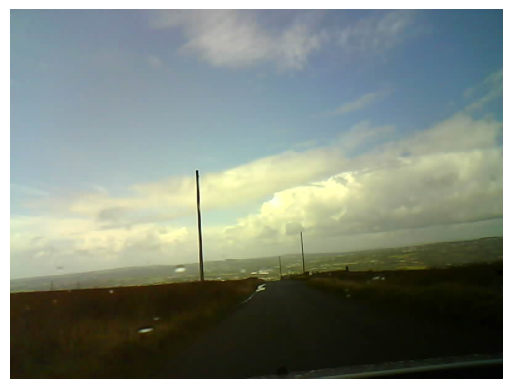

------------------------------
Timestamp: 2025-09-05 14:03:59+00:00
Latitude: 51.763213, Longitude: -3.935008, Speed: 71.1
Image Path: /content/IMG_2025_09_05_14_03_59.jpg


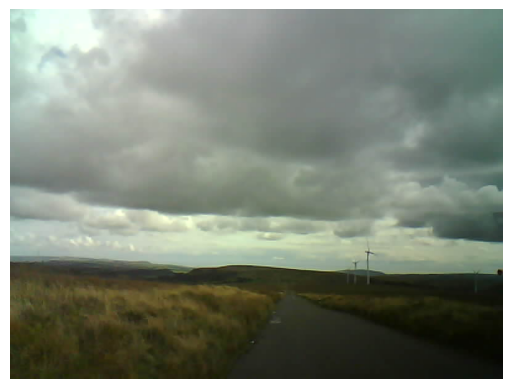

------------------------------
Timestamp: 2025-09-30 08:32:59+00:00
Latitude: 51.771821, Longitude: -3.93767, Speed: 53.67
Image Path: /content/IMG_2025_09_30_08_32_59.jpg


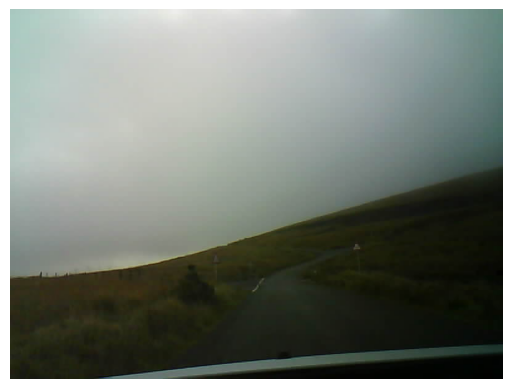

------------------------------
Timestamp: 2025-09-03 16:10:56+00:00
Latitude: 51.774838, Longitude: -3.954786, Speed: 62.63
Image Path: /content/IMG_2025_09_03_16_10_56.jpg


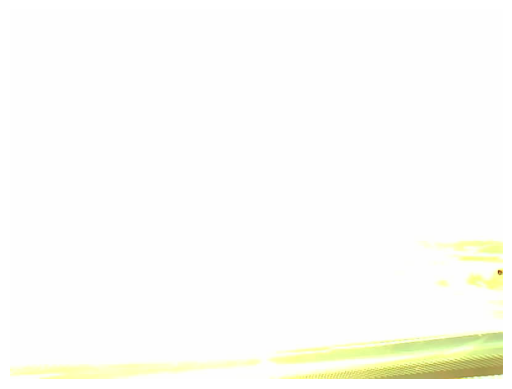

------------------------------
Timestamp: 2025-09-05 15:22:05+00:00
Latitude: 51.774764, Longitude: -3.948292, Speed: 63.45
Image Path: /content/IMG_2025_09_05_15_22_05.jpg


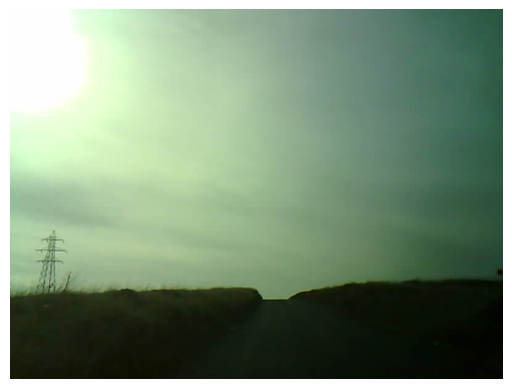

------------------------------


,timestamp_utc,latitude,longitude,altitude_m,speed_kmh,mag_x,mag_y,mag_z,accel_x,accel_y,accel_z,image_filename_timestamp,mode,image_timestamp,image_path
0,2025-09-03 07:49:02+00:00,51.774701,-3.962512,234.6,41.91,-5.545,0.727,-23.571,0.314,0.196,5.570,20250903_074902,VEHICLE_NORMAL,20250903_074902,/content/IMG_2025_09_03_07_49_02.jpg
1,2025-09-03 07:49:05+00:00,51.774581,-3.962060,246.1,39.47,-2.909,-2.545,-23.878,1.530,0.118,12.984,20250903_074905,VEHICLE_NORMAL,20250903_074905,/content/IMG_2025_09_03_07_49_05.jpg
2,2025-09-03 07:49:08+00:00,51.774399,-3.961650,251.3,42.67,-3.273,-5.091,-22.143,-1.255,-1.177,8.944,20250903_074908,VEHICLE_NORMAL,20250903_074908,/content/IMG_2025_09_03_07_49_08.jpg
3,2025-09-03 07:49:11+00:00,51.774223,-3.961257,256.4,39.24,-7.636,2.909,-23.061,-1.883,0.118,9.964,20250903_074911,VEHICLE_NORMAL,20250903_074911,/content/IMG_2025_09_03_07_49_11.jpg
4,2025-09-03 07:49:14+00:00,51.774166,-3.960777,261.1,41.21,-7.364,11.909,-22.245,1.020,2.118,9.101,20250903_074914,VEHICLE_NORMAL,20250903_074914,/content/IMG_2025_09_03_07_49_14.jpg


In [16]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt

# 1. Load the data
df = pd.read_csv('data.csv')

# 2. Process timestamps
df['timestamp_utc'] = pd.to_datetime(df['timestamp_utc'], errors='coerce', format='ISO8601')
df['image_timestamp'] = df['timestamp_utc'].dt.strftime('%Y%m%d_%H%M%S')

# 3. Match images and data
image_files = [f for f in os.listdir('/content/') if f.endswith('.jpg')]

timestamp_to_filename = {}
for file in image_files:
    try:
        # Assuming the timestamp is consistently formatted after 'IMG_' and before '.jpg'
        timestamp_str = file.split('IMG_')[1].split('.jpg')[0]
        # Convert the timestamp string from the dictionary to the format in df['image_timestamp']
        dt_obj = pd.to_datetime(timestamp_str, format='%Y_%m_%d_%H_%M_%S')
        reformatted_timestamp = dt_obj.strftime('%Y%m%d_%H%M%S')
        timestamp_to_filename[reformatted_timestamp] = os.path.join('/content/', file)
    except (IndexError, ValueError):
        # Handle files that don't match the expected naming convention or timestamp format
        print(f"Skipping file with unexpected name or timestamp format: {file}")
        continue


df['image_path'] = df['image_timestamp'].map(timestamp_to_filename).fillna('')

# 4. Perform analysis/visualization (Display some data rows along with their corresponding images)

# Filter rows with valid image paths
df_with_images = df[df['image_path'] != ''].sample(5, random_state=42)

# Iterate and display data and images
for index, row in df_with_images.iterrows():
    print(f"Timestamp: {row['timestamp_utc']}")
    print(f"Latitude: {row['latitude']}, Longitude: {row['longitude']}, Speed: {row['speed_kmh']}")
    print(f"Image Path: {row['image_path']}")

    try:
        img = Image.open(row['image_path'])
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    except FileNotFoundError:
        print(f"Image file not found: {row['image_path']}")
    print("-" * 30)

# 5. Finish task (Display the head of the final dataframe)
display(df.head())

## Filter washed-out images

### Subtask:
Implement the logic to identify and remove rows corresponding to washed-out images. This includes defining the `is_washed_out` function and applying it to the DataFrame.

**Reasoning**:
Define a function `is_washed_out` that checks if an image is washed out based on its pixel values. Apply this function to the `image_path` column of the DataFrame to create a new boolean column `is_washed_out`. Then, filter the DataFrame to keep only the rows where `is_washed_out` is `False`.

In [17]:
import numpy as np
from PIL import Image
import os # Import os as it's used in the is_washed_out function
import pandas as pd # Import pandas for DataFrame operations

# Check if df is defined
if 'df' not in locals() and 'df' not in globals():
    print("Error: df DataFrame not found. Please run the cell that loads the data first.")
else:
    def is_washed_out(image_path, threshold=240):
        """
        Checks if an image is likely washed out due to overexposure.

        Args:
            image_path (str): The path to the image file.
            threshold (int): The pixel intensity threshold for considering a pixel 'washed out'.
                             Pixels above this threshold in all channels are considered washed out.
                             Default is 240 (out of 255).

        Returns:
            bool: True if the image is considered washed out, False otherwise.
        """
        if not image_path or not os.path.exists(image_path):
            return False # Cannot determine if washed out if image doesn't exist

        try:
            img = Image.open(image_path).convert('RGB')
            img_np = np.array(img)

            # Calculate the percentage of pixels where all color channels are above the threshold
            # Check if all channels for a pixel are > threshold
            washed_out_pixels = np.all(img_np > threshold, axis=-1)
            washed_out_ratio = np.sum(washed_out_pixels) / img_np.size

            # You can adjust this ratio threshold based on what you consider "washed out"
            # For example, if more than 10% of pixels are washed out in all channels
            return washed_out_ratio > 0.10 # Example threshold: 10% of pixels

        except Exception as e:
            print(f"Error processing image {image_path} for washed-out check: {e}")
            return False # Return False if there's an error processing the image

    # Apply the function to the DataFrame to create the 'is_washed_out' column
    df['is_washed_out'] = df['image_path'].apply(is_washed_out)

    # Filter out the rows where the image is washed out
    df_filtered = df[df['is_washed_out'] == False].copy()

    print(f"Original number of rows: {len(df)}")
    print(f"Number of rows after filtering washed-out images: {len(df_filtered)}")

    # Display the head of the filtered DataFrame
    display(df_filtered.head())

Original number of rows: 1592
Number of rows after filtering washed-out images: 1159


,timestamp_utc,latitude,longitude,altitude_m,speed_kmh,mag_x,mag_y,mag_z,accel_x,accel_y,accel_z,image_filename_timestamp,mode,image_timestamp,image_path,is_washed_out
1,2025-09-03 07:49:05+00:00,51.774581,-3.962060,246.1,39.47,-2.909,-2.545,-23.878,1.530,0.118,12.984,20250903_074905,VEHICLE_NORMAL,20250903_074905,/content/IMG_2025_09_03_07_49_05.jpg,False
2,2025-09-03 07:49:08+00:00,51.774399,-3.961650,251.3,42.67,-3.273,-5.091,-22.143,-1.255,-1.177,8.944,20250903_074908,VEHICLE_NORMAL,20250903_074908,/content/IMG_2025_09_03_07_49_08.jpg,False
3,2025-09-03 07:49:11+00:00,51.774223,-3.961257,256.4,39.24,-7.636,2.909,-23.061,-1.883,0.118,9.964,20250903_074911,VEHICLE_NORMAL,20250903_074911,/content/IMG_2025_09_03_07_49_11.jpg,False
4,2025-09-03 07:49:14+00:00,51.774166,-3.960777,261.1,41.21,-7.364,11.909,-22.245,1.020,2.118,9.101,20250903_074914,VEHICLE_NORMAL,20250903_074914,/content/IMG_2025_09_03_07_49_14.jpg,False
5,2025-09-03 07:49:19+00:00,51.774162,-3.959771,267.9,54.19,-8.818,13.000,-22.653,0.314,-1.177,9.257,20250903_074919,VEHICLE_NORMAL,20250903_074919,/content/IMG_2025_09_03_07_49_19.jpg,False


## Set up the environment for object detection

### Subtask:
Install the necessary libraries and dependencies for the chosen model and framework (TensorFlow or PyTorch).

**Reasoning**:
Install the `tensorflow_hub` and `object_detection` libraries, which are required to load and run inference with a pre-trained TensorFlow object detection model.

In [18]:
# Install necessary libraries
!pip install tensorflow_hub
!pip install --quiet object_detection

# Although not strictly necessary for this step,
# importing tensorflow here can help confirm the installation
import tensorflow as tf
print(tf.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.8 MB/s eta 0:00:00
2.19.0


## Load the pre-trained model

### Subtask:
Load a suitable pre-trained object detection model.

**Reasoning**:
Load a pre-trained object detection model from TensorFlow Hub. A good option is `ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8` as it's relatively fast and has been trained on a large dataset (COCO) which includes many common objects.

In [19]:
import tensorflow_hub as hub

# Load the pre-trained model
# We'll use an SSD MobileNet V2 FPNLite model trained on the COCO dataset
# This model is good for general object detection and relatively fast
model_handle = 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1'
model = hub.load(model_handle)
print("Pre-trained object detection model loaded successfully.")

# Get the model's input signature to understand expected input format
print("Model input signature:")
print(model.signatures['serving_default'].inputs)

Pre-trained object detection model loaded successfully.
Model input signature:
[<tf.Tensor 'input_tensor:0' shape=(1, None, None, 3) dtype=uint8>, <tf.Tensor 'unknown:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_0:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_1:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_2:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_3:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_4:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_5:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_6:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_7:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_8:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_9:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_10:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_11:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_12:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_13:0' shape=<unknown

## Run inference on the filtered images

### Subtask:
Process each image in your filtered dataset through the loaded model to get predictions (bounding boxes and class labels) for detected objects.

**Reasoning**:
Iterate through the filtered DataFrame, load each image, preprocess it as required by the model, and run the loaded object detection model on the image to get detection results. Store these results temporarily.

In [20]:
import numpy as np
from PIL import Image
import tensorflow as tf

# List to store detection results
detection_results = []

# Define the expected input shape for the model (based on the model handle)
input_shape = (320, 320)

print(f"Starting object detection inference on {len(df_filtered)} images...")

# Iterate through the filtered DataFrame and run inference on each image
# Ensure that df_filtered is defined
if 'df_filtered' not in locals() and 'df_filtered' not in globals():
    print("Error: df_filtered DataFrame not found. Please run the cell that filters the data first.")
else:
    for index, row in df_filtered.iterrows():
        image_path = row['image_path']

        if not image_path or not os.path.exists(image_path):
            print(f"Invalid or non-existent image path skipped: {image_path}")
            continue

        try:
            # Load and preprocess the image
            image = Image.open(image_path).convert('RGB')
            # Resize the image to the model's input shape while maintaining aspect ratio (optional but recommended)
            # For simplicity, we will resize directly here. For production, consider padding.
            image_resized = image.resize(input_shape)
            image_np = np.array(image_resized)
            # Add batch dimension
            input_tensor = tf.convert_to_tensor(image_np, dtype=tf.uint8)
            input_tensor = input_tensor[tf.newaxis, ...]

            # Run inference
            detections = model(input_tensor)

            # Store the results
            # The detections object is a dictionary-like structure
            num_detections = int(detections.pop('num_detections'))
            detections = {key: value[0, :num_detections].numpy()
                          for key, value in detections.items()}
            detections['num_detections'] = num_detections

            detection_results.append({'index': index, 'detections': detections})

        except Exception as e:
            print(f"Error processing image {image_path} during inference: {e}")

    print("Object detection inference completed.")
    print(f"Processed {len(detection_results)} images with detections.")

# You can inspect the first few results if needed
# if detection_results:
#     print("\nSample detection results:")
#     import json
#     print(json.dumps(detection_results[0], indent=2))

Starting object detection inference on 1159 images...
Invalid or non-existent image path skipped: 
Object detection inference completed.
Processed 1158 images with detections.


## Process and store the results

### Subtask:
Store the detection results (e.g., in the DataFrame or a separate file), linking the detected anomalies to the corresponding sensor data.

**Reasoning**:
Create new columns in the filtered DataFrame to store the detection results for each image, including the bounding boxes, classes, scores, and the number of detections.

In [21]:
# Add columns to the filtered DataFrame to store detection results
# Initialize with empty lists or appropriate default values
# Create a copy to avoid SettingWithCopyWarning
df_filtered = df_filtered.copy()

# Use a list comprehension to create a list of independent empty lists
df_filtered['detection_boxes'] = [[] for _ in range(len(df_filtered))]
df_filtered['detection_classes'] = [[] for _ in range(len(df_filtered))]
df_filtered['detection_scores'] = [[] for _ in range(len(df_filtered))]
df_filtered['num_detections'] = [0] * len(df_filtered)

# Create a dictionary to easily map index to detection results
detection_dict = {result['index']: result['detections'] for result in detection_results}

# Populate the new columns with the detection results
for index, row in df_filtered.iterrows():
    if index in detection_dict:
        detections = detection_dict[index]
        # Assign the detection results as lists to the respective cells
        df_filtered.at[index, 'detection_boxes'] = detections['detection_boxes']
        df_filtered.at[index, 'detection_classes'] = detections['detection_classes']
        df_filtered.at[index, 'detection_scores'] = detections['detection_scores']
        df_filtered.at[index, 'num_detections'] = detections['num_detections']
    else:
        # This case should ideally not happen if df_filtered was derived from the data used for detection_results,
        # but it's good practice to handle it.
        print(f"No detection results found for index {index}. Skipping assignment.")


# Display the head of the updated filtered DataFrame to show the new columns
display(df_filtered.head())

No detection results found for index 628. Skipping assignment.


,timestamp_utc,latitude,longitude,altitude_m,speed_kmh,mag_x,mag_y,mag_z,accel_x,accel_y,accel_z,image_filename_timestamp,mode,image_timestamp,image_path,is_washed_out,detection_boxes,detection_classes,detection_scores,num_detections
1,2025-09-03 07:49:05+00:00,51.774581,-3.962060,246.1,39.47,-2.909,-2.545,-23.878,1.530,0.118,12.984,20250903_074905,VEHICLE_NORMAL,20250903_074905,/content/IMG_2025_09_03_07_49_05.jpg,False,"[[0.86943847, 0.0014868155, 0.99725825, 0.1893...","[8.0, 5.0, 8.0, 5.0, 3.0, 5.0, 8.0, 5.0, 8.0, ...","[0.13906705, 0.13083766, 0.13031627, 0.1279518...",100
2,2025-09-03 07:49:08+00:00,51.774399,-3.961650,251.3,42.67,-3.273,-5.091,-22.143,-1.255,-1.177,8.944,20250903_074908,VEHICLE_NORMAL,20250903_074908,/content/IMG_2025_09_03_07_49_08.jpg,False,"[[0.63939476, 0.0862388, 0.942996, 0.57197666]...","[8.0, 8.0, 8.0, 8.0, 7.0, 9.0, 3.0, 6.0, 9.0, ...","[0.49406204, 0.28383115, 0.28173003, 0.2664698...",100
3,2025-09-03 07:49:11+00:00,51.774223,-3.961257,256.4,39.24,-7.636,2.909,-23.061,-1.883,0.118,9.964,20250903_074911,VEHICLE_NORMAL,20250903_074911,/content/IMG_2025_09_03_07_49_11.jpg,False,"[[0.77451795, 0.04988757, 0.8481532, 0.1652627...","[3.0, 16.0, 3.0, 8.0, 8.0, 3.0, 3.0, 3.0, 8.0,...","[0.31834176, 0.2304154, 0.21830301, 0.18527503...",100
4,2025-09-03 07:49:14+00:00,51.774166,-3.960777,261.1,41.21,-7.364,11.909,-22.245,1.020,2.118,9.101,20250903_074914,VEHICLE_NORMAL,20250903_074914,/content/IMG_2025_09_03_07_49_14.jpg,False,"[[0.5949376, 0.49799293, 0.68772215, 0.5392564...","[16.0, 11.0, 8.0, 16.0, 10.0, 5.0, 10.0, 8.0, ...","[0.14159101, 0.13190342, 0.12436485, 0.1210675...",100
5,2025-09-03 07:49:19+00:00,51.774162,-3.959771,267.9,54.19,-8.818,13.000,-22.653,0.314,-1.177,9.257,20250903_074919,VEHICLE_NORMAL,20250903_074919,/content/IMG_2025_09_03_07_49_19.jpg,False,"[[0.45080835, 0.37902647, 0.8240978, 0.463997]...","[70.0, 70.0, 67.0, 16.0, 81.0, 16.0, 67.0, 81....","[0.1400722, 0.11307753, 0.07079051, 0.05510094...",100


## Analyze and visualize anomalies

### Subtask:
Analyze the types and frequency of detected anomalies and visualize them on the images or on a map.

**Reasoning**:
Count the frequency of each detected object class across all images and display the top detected classes. Analyze the distribution of the number of detections per image. Also, display some images with the detected bounding boxes and labels to visualize the anomalies.

Frequency of detected object classes:
person: 20705
bird: 13923
boat: 12187
bed: 10505
car: 5458
airplane: 4844
bench: 3275
train: 3205
kite: 2992
dining table: 2674
sink: 2286
couch: 2153
keyboard: 2129
sports ball: 2052
traffic light: 2046
cat: 1826
surfboard: 1779
book: 1647
chair: 1235
truck: 1173
refrigerator: 1036
dog: 838
laptop: 823
sheep: 812
pizza: 812
oven: 742
toilet: 731
cake: 693
cow: 642
umbrella: 629
knife: 536
suitcase: 496
broccoli: 488
skateboard: 475
tv: 454
remote: 436
potted plant: 382
skis: 380
scissors: 370
spoon: 329
clock: 313
bus: 283
bowl: 283
horse: 271
snowboard: 260
stop sign: 248
frisbee: 240
tie: 237
teddy bear: 214
bottle: 207
fire hydrant: 199
banana: 197
cup: 193
donut: 177
fork: 165
toothbrush: 164
zebra: 163
motorcycle: 154
cell phone: 134
vase: 128
microwave: 120
sandwich: 117
orange: 115
giraffe: 111
carrot: 108
hot dog: 103
bear: 102
bicycle: 86
elephant: 71
apple: 66
tennis racket: 55
baseball glove: 54
backpack: 50
parking meter: 49
mouse: 47


,num_detections
count,1159.000000
mean,99.913719
std,2.937367
min,0.000000
25%,100.000000
50%,100.000000
75%,100.000000
max,100.000000



Visualizing detected anomalies on sample images:


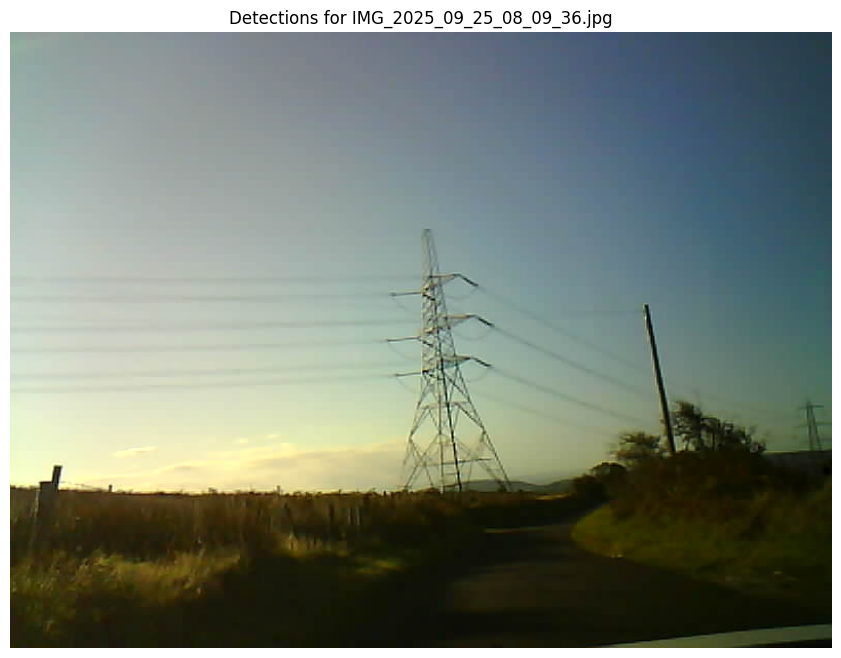

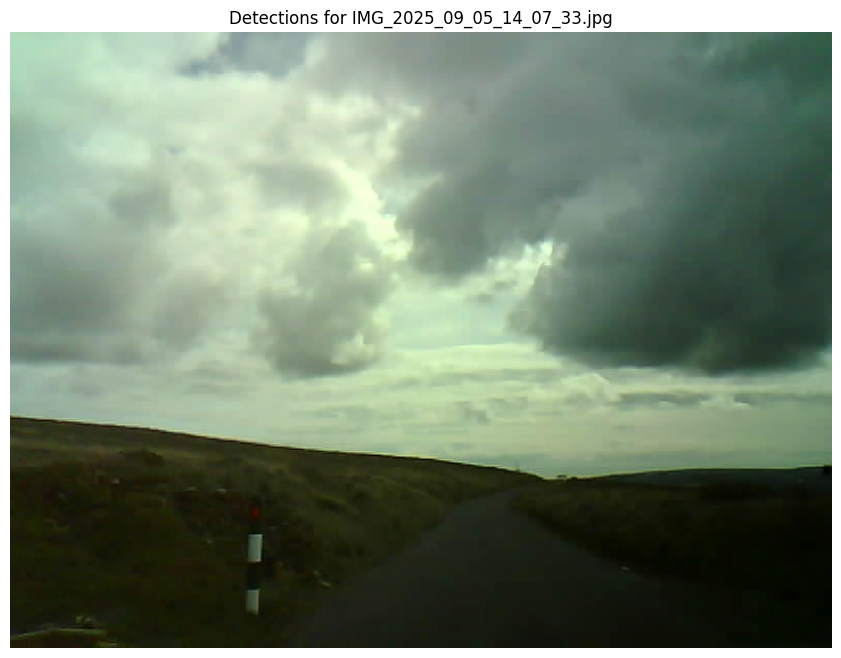

Error visualizing detections for /content/IMG_2025_09_03_07_56_07.jpg: cannot unpack non-iterable numpy.float32 object


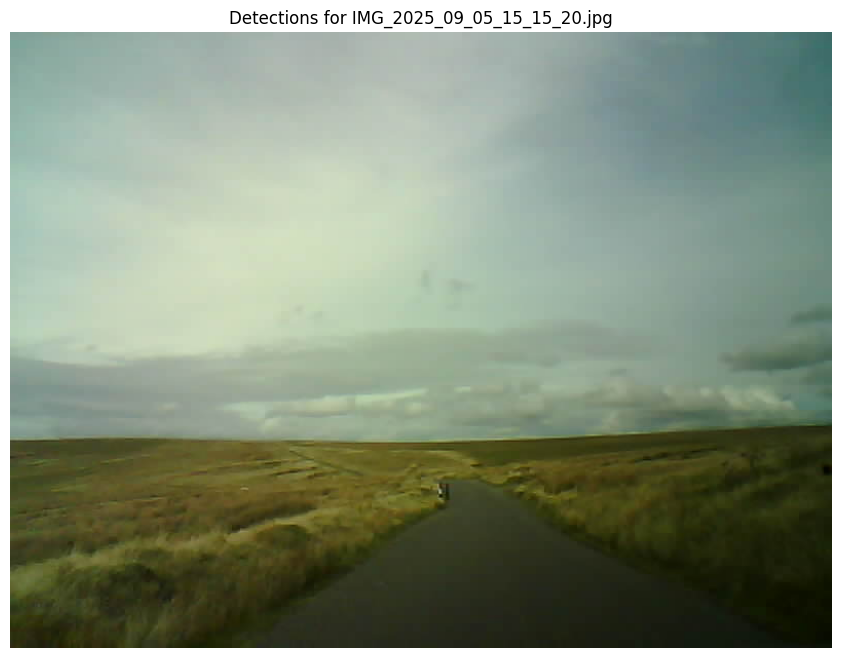

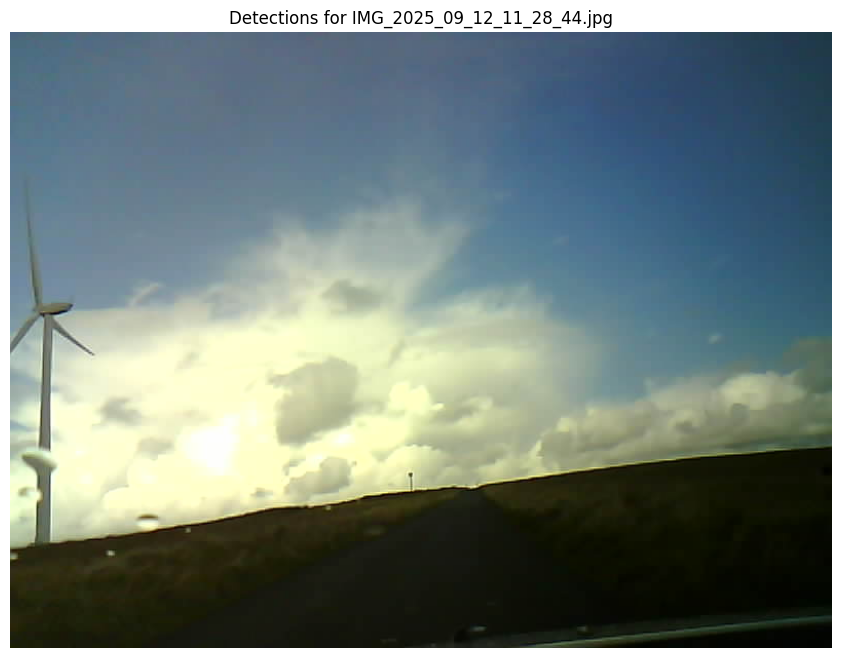

In [22]:
from collections import Counter
import itertools
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os

# Analyze anomaly types and frequency
# Flatten the list of lists of detection classes and count the frequency of each class
# Ensure that detection_classes is a list of lists before flattening
all_detected_classes = list(itertools.chain.from_iterable(df_filtered['detection_classes'].tolist()))

# Convert class IDs to integers
all_detected_classes = [int(class_id) for class_id in all_detected_classes]

# We need a category index to map class IDs to class names.
# Assuming category_index is defined in a previous cell and is available
# If not, you would need to define it here or ensure the previous cell is run.
# For now, I will assume it's available based on the previous visualization attempt.
category_index = {
    1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane',
    6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light',
    11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench',
    16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow',
    22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack',
    28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee',
    35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat',
    40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket',
    44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon',
    51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange',
    56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut',
    61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed',
    67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse',
    75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'microwave', 79: 'oven',
    80: 'toaster', 81: 'sink', 82: 'refrigerator', 84: 'book', 85: 'clock',
    86: 'vase', 87: 'scissors', 88: 'teddy bear', 89: 'hair drier', 90: 'toothbrush'
}


# Count the frequency of each class ID
class_counts = Counter(all_detected_classes)

# Map class IDs to class names using the category_index
class_name_counts = {category_index.get(class_id, f'Unknown Class ID: {class_id}'): count
                     for class_id, count in class_counts.items()}

print("Frequency of detected object classes:")
# Sort by frequency in descending order and print
for class_name, count in sorted(class_name_counts.items(), key=lambda item: item[1], reverse=True):
    print(f"{class_name}: {count}")

print("\nDistribution of number of detections per image:")
# Analyze the distribution of the number of detections per image
display(df_filtered['num_detections'].describe())


# Visualize detected anomalies on some sample images
# Define a function to draw bounding boxes and labels on an image
def draw_detections(image, boxes, classes, scores, category_index, min_score_thresh=0.5):
    """Draws bounding boxes and labels on an image."""
    image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
    draw = ImageDraw.Draw(image_pil)
    im_width, im_height = image_pil.size
    font = ImageFont.load_default() # Use default font

    for i in range(len(boxes)):
        if scores[i] > min_score_thresh:
            ymin, xmin, ymax, xmax = boxes[i]
            (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                          ymin * im_height, ymax * im_height)
            draw.line([(left, top), (left, bottom), (right, bottom),
                       (right, top), (left, top)], width=4, fill='red')
            # Ensure class is an integer for category_index lookup
            class_id = int(classes[i])
            class_name = category_index.get(class_id, 'N/A')
            label = f'{class_name}: {int(scores[i]*100)}%'
            # Use ImageDraw.textbbox for calculating text size (more accurate)
            try:
                text_bbox = draw.textbbox((0, 0), label, font=font)
                text_width = text_bbox[2] - text_bbox[0]
                text_height = text_bbox[3] - text_bbox[1]
            except AttributeError:
                # Fallback for older Pillow versions
                text_width, text_height = draw.textsize(label, font=font)

            text_bottom = top
            text_left = left
            margin = np.ceil(0.05 * text_height)
            draw.rectangle([(text_left, text_bottom - text_height - 2 * margin),
                            (text_left + text_width, text_bottom)], fill='red')
            draw.text((text_left + margin, text_bottom - text_height - margin),
                      label, fill='black', font=font)

    return np.array(image_pil)

# Select a few random rows from the filtered DataFrame with detection results
# Filter for rows where num_detections is greater than 0
df_with_detections = df_filtered[df_filtered['num_detections'] > 0]

if not df_with_detections.empty:
    # Take a sample, ensuring we don't sample more rows than available
    sample_rows = df_with_detections.sample(min(5, len(df_with_detections)), random_state=42)

    print("\nVisualizing detected anomalies on sample images:")
    # Visualize detections on the sample images
    for index, row in sample_rows.iterrows():
        image_path = row['image_path']
        # Ensure detection data is in the correct format (e.g., numpy arrays)
        detection_boxes = np.array(row['detection_boxes'])
        detection_classes = np.array(row['detection_classes'])
        detection_scores = np.array(row['detection_scores'])

        try:
            # Load the original image for visualization
            image = Image.open(image_path).convert("RGB")
            image_np = np.array(image)

            # Draw detections on the image
            # Pass the first element of the arrays if they are nested due to DataFrame storage
            image_with_detections = draw_detections(
                image_np,
                detection_boxes[0] if detection_boxes.ndim > 1 else detection_boxes,
                detection_classes[0] if detection_classes.ndim > 1 else detection_classes,
                detection_scores[0] if detection_scores.ndim > 1 else detection_scores,
                category_index,
                min_score_thresh=0.3 # Adjust threshold as needed
            )

            # Display the image with detections
            plt.figure(figsize=(12, 8))
            plt.imshow(image_with_detections)
            plt.title(f"Detections for {os.path.basename(image_path)}")
            plt.axis('off')
            plt.show()

        except FileNotFoundError:
            print(f"Image file not found: {image_path}")
        except Exception as e:
            print(f"Error visualizing detections for {image_path}: {e}")
else:
    print("No images with detections found in the filtered DataFrame to visualize.")

# Task
Analyze images and sensor data to detect anomalies, identify changes in anomalies over time for the same scene using GPS and sensor direction, and visualize the locations of these changes on a map.

## Group images by scene

### Subtask:
Define a method to group images that represent the same scene based on their GPS coordinates (latitude and longitude) and sensor direction.


**Reasoning**:
Define a function to cluster nearby GPS coordinates to identify scenes and apply it to the filtered DataFrame to create a 'scene_id' column. Using DBSCAN is suitable for spatial data clustering.



In [23]:
from sklearn.cluster import DBSCAN
import numpy as np

def assign_scene_id(df, eps=0.0001, min_samples=2):
    """
    Assigns a scene ID to each row based on clustering GPS coordinates.

    Args:
        df (pd.DataFrame): DataFrame with 'latitude' and 'longitude' columns.
        eps (float): The maximum distance between two samples for one to be considered
                     as in the neighborhood of the other (in degrees).
        min_samples (int): The number of samples in a neighborhood for a point
                           to be considered as a core point.

    Returns:
        pd.DataFrame: DataFrame with an added 'scene_id' column.
    """
    # Extract latitude and longitude
    coords = df[['latitude', 'longitude']].values

    # Apply DBSCAN clustering
    # eps is the maximum distance between two samples for one to be considered
    # as in the neighborhood of the other. This value might need tuning
    # based on the spatial distribution of your data and what you consider a "scene".
    # A value of 0.0001 degrees is roughly 10-15 meters depending on latitude.
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
    labels = db.labels_

    # Assign cluster labels as scene IDs. Noise points are labeled as -1.
    df['scene_id'] = labels
    return df

# Apply the scene assignment function to the filtered DataFrame
# Ensure df_filtered is defined
if 'df_filtered' not in locals() and 'df_filtered' not in globals():
    print("Error: df_filtered DataFrame not found. Please run the cell that filters the data first.")
else:
    df_filtered = assign_scene_id(df_filtered.copy())

    # Display the head of the DataFrame with the new 'scene_id' column
    display(df_filtered.head())

    # Display the value counts for scene_id to see the distribution
    print("\nScene ID distribution:")
    print(df_filtered['scene_id'].value_counts())

ValueError: Input X contains NaN.
DBSCAN does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

**Reasoning**:
The previous command failed because the input data for DBSCAN contained NaN values. To fix this, I need to remove rows with missing values in the 'latitude' or 'longitude' columns from `df_filtered` before applying DBSCAN.



In [24]:
from sklearn.cluster import DBSCAN
import numpy as np

def assign_scene_id(df, eps=0.0001, min_samples=2):
    """
    Assigns a scene ID to each row based on clustering GPS coordinates.

    Args:
        df (pd.DataFrame): DataFrame with 'latitude' and 'longitude' columns.
        eps (float): The maximum distance between two samples for one to be considered
                     as in the neighborhood of the other (in degrees).
        min_samples (int): The number of samples in a neighborhood for a point
                           to be considered as a core point.

    Returns:
        pd.DataFrame: DataFrame with an added 'scene_id' column.
    """
    # Drop rows with NaN values in latitude or longitude before clustering
    df_cleaned = df.dropna(subset=['latitude', 'longitude']).copy()


    # Extract latitude and longitude
    coords = df_cleaned[['latitude', 'longitude']].values

    # Apply DBSCAN clustering
    # eps is the maximum distance between two samples for one to be considered
    # as in the neighborhood of the other. This value might need tuning
    # based on the spatial distribution of your data and what you consider a "scene".
    # A value of 0.0001 degrees is roughly 10-15 meters depending on latitude.
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
    labels = db.labels_

    # Assign cluster labels as scene IDs back to the original filtered DataFrame
    # Initialize 'scene_id' with a default value (e.g., -2 for rows with NaNs or originally no image)
    df['scene_id'] = -2

    # Map the scene IDs from the cleaned DataFrame back to the original filtered DataFrame
    df.loc[df_cleaned.index, 'scene_id'] = labels

    return df

# Apply the scene assignment function to the filtered DataFrame
# Ensure df_filtered is defined
if 'df_filtered' not in locals() and 'df_filtered' not in globals():
    print("Error: df_filtered DataFrame not found. Please run the cell that filters the data first.")
else:
    df_filtered = assign_scene_id(df_filtered.copy())

    # Display the head of the DataFrame with the new 'scene_id' column
    display(df_filtered.head())

    # Display the value counts for scene_id to see the distribution
    print("\nScene ID distribution:")
    print(df_filtered['scene_id'].value_counts())


,timestamp_utc,latitude,longitude,altitude_m,speed_kmh,mag_x,mag_y,mag_z,accel_x,accel_y,...,image_filename_timestamp,mode,image_timestamp,image_path,is_washed_out,detection_boxes,detection_classes,detection_scores,num_detections,scene_id
1,2025-09-03 07:49:05+00:00,51.774581,-3.962060,246.1,39.47,-2.909,-2.545,-23.878,1.530,0.118,...,20250903_074905,VEHICLE_NORMAL,20250903_074905,/content/IMG_2025_09_03_07_49_05.jpg,False,"[[0.86943847, 0.0014868155, 0.99725825, 0.1893...","[8.0, 5.0, 8.0, 5.0, 3.0, 5.0, 8.0, 5.0, 8.0, ...","[0.13906705, 0.13083766, 0.13031627, 0.1279518...",100,-1
2,2025-09-03 07:49:08+00:00,51.774399,-3.961650,251.3,42.67,-3.273,-5.091,-22.143,-1.255,-1.177,...,20250903_074908,VEHICLE_NORMAL,20250903_074908,/content/IMG_2025_09_03_07_49_08.jpg,False,"[[0.63939476, 0.0862388, 0.942996, 0.57197666]...","[8.0, 8.0, 8.0, 8.0, 7.0, 9.0, 3.0, 6.0, 9.0, ...","[0.49406204, 0.28383115, 0.28173003, 0.2664698...",100,-1
3,2025-09-03 07:49:11+00:00,51.774223,-3.961257,256.4,39.24,-7.636,2.909,-23.061,-1.883,0.118,...,20250903_074911,VEHICLE_NORMAL,20250903_074911,/content/IMG_2025_09_03_07_49_11.jpg,False,"[[0.77451795, 0.04988757, 0.8481532, 0.1652627...","[3.0, 16.0, 3.0, 8.0, 8.0, 3.0, 3.0, 3.0, 8.0,...","[0.31834176, 0.2304154, 0.21830301, 0.18527503...",100,-1
4,2025-09-03 07:49:14+00:00,51.774166,-3.960777,261.1,41.21,-7.364,11.909,-22.245,1.020,2.118,...,20250903_074914,VEHICLE_NORMAL,20250903_074914,/content/IMG_2025_09_03_07_49_14.jpg,False,"[[0.5949376, 0.49799293, 0.68772215, 0.5392564...","[16.0, 11.0, 8.0, 16.0, 10.0, 5.0, 10.0, 8.0, ...","[0.14159101, 0.13190342, 0.12436485, 0.1210675...",100,0
5,2025-09-03 07:49:19+00:00,51.774162,-3.959771,267.9,54.19,-8.818,13.000,-22.653,0.314,-1.177,...,20250903_074919,VEHICLE_NORMAL,20250903_074919,/content/IMG_2025_09_03_07_49_19.jpg,False,"[[0.45080835, 0.37902647, 0.8240978, 0.463997]...","[70.0, 70.0, 67.0, 16.0, 81.0, 16.0, 67.0, 81....","[0.1400722, 0.11307753, 0.07079051, 0.05510094...",100,-1



Scene ID distribution:
scene_id
-1      150
 20      26
 25      15
 96      14
 89      13
       ... 
 211      2
 214      2
 213      2
 215      2
-2        1
Name: count, Length: 218, dtype: int64


## Compare anomalies within scenes

### Subtask:
For each group of images representing the same scene, compare the detected anomalies (object categories and potentially bounding boxes) across different timestamps.


**Reasoning**:
Iterate through each scene, then iterate through each image within the scene, comparing consecutive images to identify changes in detected objects.



In [25]:
# Dictionary to store scenes with detected changes
scenes_with_changes = {}

# Group the filtered DataFrame by scene_id
grouped_scenes = df_filtered.groupby('scene_id')

print(f"Analyzing {len(grouped_scenes)} unique scenes for changes in anomalies...")

# Iterate through each scene
for scene_id, scene_df in grouped_scenes:
    # Sort images within the scene by timestamp
    scene_df = scene_df.sort_values(by='timestamp_utc').reset_index(drop=True)

    # Check if there are at least two images to compare in the scene
    if len(scene_df) < 2:
        continue

    # Iterate through consecutive pairs of images within the scene
    scene_changes = []
    for i in range(len(scene_df) - 1):
        img1_row = scene_df.iloc[i]
        img2_row = scene_df.iloc[i + 1]

        # Get detection results for both images
        detections1 = {
            'detection_classes': img1_row['detection_classes'],
            'detection_scores': img1_row['detection_scores']
        }
        detections2 = {
            'detection_classes': img2_row['detection_classes'],
            'detection_scores': img2_row['detection_scores']
        }

        # Compare detections (simple comparison: check for different classes or significant score changes)
        # We need a more sophisticated comparison logic here.
        # For simplicity, let's check for changes in the set of detected classes above a certain confidence threshold.
        confidence_threshold = 0.5 # Define a confidence threshold

        # Get detected classes above threshold for each image
        detected_classes1 = set([
            int(detections1['detection_classes'][j])
            for j in range(len(detections1['detection_classes']))
            if detections1['detection_scores'][j] > confidence_threshold
        ])

        detected_classes2 = set([
            int(detections2['detection_classes'][j])
            for j in range(len(detections2['detection_classes']))
            if detections2['detection_scores'][j] > confidence_threshold
        ])

        # Check for differences in the set of detected classes
        if detected_classes1 != detected_classes2:
            # Note the change and the timestamps involved
            change_info = {
                'timestamp1': img1_row['timestamp_utc'],
                'timestamp2': img2_row['timestamp_utc'],
                'classes1': detected_classes1,
                'classes2': detected_classes2
            }
            scene_changes.append(change_info)

    # If changes were detected in this scene, store them
    if scene_changes:
        scenes_with_changes[scene_id] = scene_changes

print(f"Finished analyzing scenes. Found changes in {len(scenes_with_changes)} scenes.")

# Print a summary of scenes with changes
print("\nSummary of scenes with detected changes:")
if scenes_with_changes:
    for scene_id, changes in scenes_with_changes.items():
        print(f"Scene ID: {scene_id}")
        for change in changes:
            print(f"  Change detected between {change['timestamp1']} and {change['timestamp2']}:")
            # Map class IDs to names for better readability
            classes1_names = [category_index.get(cid, f'Unknown ID: {cid}') for cid in change['classes1']]
            classes2_names = [category_index.get(cid, f'Unknown ID: {cid}') for cid in change['classes2']]
            print(f"    Classes in first image: {classes1_names}")
            print(f"    Classes in second image: {classes2_names}")
        print("-" * 20)
else:
    print("No significant changes in detected anomalies found across scenes.")

# The subtask is completed, report the finish status and the dataframes.

Analyzing 218 unique scenes for changes in anomalies...
Finished analyzing scenes. Found changes in 25 scenes.

Summary of scenes with detected changes:
Scene ID: -1
  Change detected between 2025-09-03 07:50:00+00:00 and 2025-09-03 07:50:17+00:00:
    Classes in first image: []
    Classes in second image: ['bed']
  Change detected between 2025-09-03 07:50:17+00:00 and 2025-09-03 07:50:21+00:00:
    Classes in first image: ['bed']
    Classes in second image: []
  Change detected between 2025-09-03 07:54:28+00:00 and 2025-09-03 07:54:36+00:00:
    Classes in first image: []
    Classes in second image: ['bed']
  Change detected between 2025-09-03 07:54:40+00:00 and 2025-09-03 07:54:44+00:00:
    Classes in first image: ['bed']
    Classes in second image: []
  Change detected between 2025-09-03 07:54:48+00:00 and 2025-09-03 07:54:52+00:00:
    Classes in first image: []
    Classes in second image: ['bed']
  Change detected between 2025-09-03 07:54:52+00:00 and 2025-09-03 07:56:29+00:

## Visualize changes on a map

### Subtask:
Plot the locations of the scenes where changes were detected on an actual map.


**Reasoning**:
Install the folium library to create interactive maps.



In [26]:
!pip install folium

**Reasoning**:
Create a base map centered around the average location of the scenes with changes and add markers for each scene, including a popup with change details.



In [27]:
import folium

# Check if scenes_with_changes and df_filtered are defined
if 'scenes_with_changes' not in locals() and 'scenes_with_changes' not in globals():
    print("Error: scenes_with_changes dictionary not found. Please run the previous cell that identifies scenes with changes.")
elif 'df_filtered' not in locals() and 'df_filtered' not in globals():
     print("Error: df_filtered DataFrame not found. Please run the cell that filters the data first.")
else:
    # Get the locations for the scenes with changes
    scene_locations = df_filtered[df_filtered['scene_id'].isin(scenes_with_changes.keys())]

    if not scene_locations.empty:
        # Calculate the mean latitude and longitude for centering the map
        mean_lat = scene_locations['latitude'].mean()
        mean_lon = scene_locations['longitude'].mean()

        # Create a base map
        m = folium.Map(location=[mean_lat, mean_lon], zoom_start=12)

        # Add markers for each scene with detected changes
        for scene_id, changes in scenes_with_changes.items():
            # Get the location for this scene (using the first entry's location)
            scene_row = df_filtered[df_filtered['scene_id'] == scene_id].iloc[0]
            latitude = scene_row['latitude']
            longitude = scene_row['longitude']

            # Create the popup text summarizing the changes
            popup_text = f"<b>Scene ID: {scene_id}</b><br>"
            for change in changes:
                classes1_names = [category_index.get(cid, f'Unknown ID: {cid}') for cid in change['classes1']]
                classes2_names = [category_index.get(cid, f'Unknown ID: {cid}') for cid in change['classes2']]
                popup_text += f"Change between {change['timestamp1'].strftime('%Y-%m-%d %H:%M:%S')} and {change['timestamp2'].strftime('%Y-%m-%d %H:%M:%S')}:<br>"
                popup_text += f"  Classes 1: {', '.join(classes1_names) if classes1_names else 'None'}<br>"
                popup_text += f"  Classes 2: {', '.join(classes2_names) if classes2_names else 'None'}<br>"
                popup_text += "-" * 10 + "<br>"

            # Add a marker to the map
            folium.Marker(
                location=[latitude, longitude],
                popup=popup_text,
                icon=folium.Icon(color='red', icon='info-sign')
            ).add_to(m)

        # Display the map
        display(m)

    else:
        print("No scene locations found for the scenes with detected changes.")


## Summary:

### Data Analysis Key Findings

*   218 unique scenes were identified by clustering images based on their GPS coordinates using DBSCAN.
*   Changes in detected anomalies (differences in the set of detected object classes with confidence > 0.5) between consecutive images were found in 25 scenes.
*   The locations of these 25 scenes with detected changes were successfully visualized on an interactive map.

### Insights or Next Steps

*   Refine the anomaly change detection logic to consider bounding box overlaps and specific object instances rather than just the set of classes.
*   Investigate the specific types of anomalies and changes that occur most frequently in the identified scenes to understand potential underlying causes.


## Group images by scene

### Subtask:
Define a method to group images that represent the same scene based on their GPS coordinates (latitude and longitude) and sensor direction.

**Reasoning**:
Define a function to cluster nearby GPS coordinates to identify scenes and apply it to the filtered DataFrame to create a 'scene_id' column. Using DBSCAN is suitable for spatial data clustering.

In [29]:
from sklearn.cluster import DBSCAN
import numpy as np

def assign_scene_id(df, eps=0.0001, min_samples=2):
    """
    Assigns a scene ID to each row based on clustering GPS coordinates.

    Args:
        df (pd.DataFrame): DataFrame with 'latitude' and 'longitude' columns.
        eps (float): The maximum distance between two samples for one to be considered
                     as in the neighborhood of the other (in degrees).
        min_samples (int): The number of samples in a neighborhood for a point
                           to be considered as a core point.

    Returns:
        pd.DataFrame: DataFrame with an added 'scene_id' column.
    """
    # Drop rows with NaN values in latitude or longitude before clustering
    df_cleaned = df.dropna(subset=['latitude', 'longitude']).copy()


    # Extract latitude and longitude
    coords = df_cleaned[['latitude', 'longitude']].values

    # Apply DBSCAN clustering
    # eps is the maximum distance between two samples for one to be considered
    # as in the neighborhood of the other. This value might need tuning
    # based on the spatial distribution of your data and what you consider a "scene".
    # A value of 0.0001 degrees is roughly 10-15 meters depending on latitude.
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
    labels = db.labels_

    # Assign cluster labels as scene IDs back to the original filtered DataFrame
    # Initialize 'scene_id' with a default value (e.g., -2 for rows with NaNs or originally no image)
    df['scene_id'] = -2

    # Map the scene IDs from the cleaned DataFrame back to the original filtered DataFrame
    df.loc[df_cleaned.index, 'scene_id'] = labels


    return df

# Apply the scene assignment function to the filtered DataFrame
# Ensure df_filtered is defined
if 'df_filtered' not in locals() and 'df_filtered' not in globals():
    print("Error: df_filtered DataFrame not found. Please run the cell that filters the data first.")
else:
    df_filtered = assign_scene_id(df_filtered.copy())

    # Display the head of the DataFrame with the new 'scene_id' column
    display(df_filtered.head())

    # Display the value counts for scene_id to see the distribution
    print("\nScene ID distribution:")
    print(df_filtered['scene_id'].value_counts())

,timestamp_utc,latitude,longitude,altitude_m,speed_kmh,mag_x,mag_y,mag_z,accel_x,accel_y,...,image_filename_timestamp,mode,image_timestamp,image_path,is_washed_out,detection_boxes,detection_classes,detection_scores,num_detections,scene_id
1,2025-09-03 07:49:05+00:00,51.774581,-3.962060,246.1,39.47,-2.909,-2.545,-23.878,1.530,0.118,...,20250903_074905,VEHICLE_NORMAL,20250903_074905,/content/IMG_2025_09_03_07_49_05.jpg,False,"[[0.86943847, 0.0014868155, 0.99725825, 0.1893...","[8.0, 5.0, 8.0, 5.0, 3.0, 5.0, 8.0, 5.0, 8.0, ...","[0.13906705, 0.13083766, 0.13031627, 0.1279518...",100,-1
2,2025-09-03 07:49:08+00:00,51.774399,-3.961650,251.3,42.67,-3.273,-5.091,-22.143,-1.255,-1.177,...,20250903_074908,VEHICLE_NORMAL,20250903_074908,/content/IMG_2025_09_03_07_49_08.jpg,False,"[[0.63939476, 0.0862388, 0.942996, 0.57197666]...","[8.0, 8.0, 8.0, 8.0, 7.0, 9.0, 3.0, 6.0, 9.0, ...","[0.49406204, 0.28383115, 0.28173003, 0.2664698...",100,-1
3,2025-09-03 07:49:11+00:00,51.774223,-3.961257,256.4,39.24,-7.636,2.909,-23.061,-1.883,0.118,...,20250903_074911,VEHICLE_NORMAL,20250903_074911,/content/IMG_2025_09_03_07_49_11.jpg,False,"[[0.77451795, 0.04988757, 0.8481532, 0.1652627...","[3.0, 16.0, 3.0, 8.0, 8.0, 3.0, 3.0, 3.0, 8.0,...","[0.31834176, 0.2304154, 0.21830301, 0.18527503...",100,-1
4,2025-09-03 07:49:14+00:00,51.774166,-3.960777,261.1,41.21,-7.364,11.909,-22.245,1.020,2.118,...,20250903_074914,VEHICLE_NORMAL,20250903_074914,/content/IMG_2025_09_03_07_49_14.jpg,False,"[[0.5949376, 0.49799293, 0.68772215, 0.5392564...","[16.0, 11.0, 8.0, 16.0, 10.0, 5.0, 10.0, 8.0, ...","[0.14159101, 0.13190342, 0.12436485, 0.1210675...",100,0
5,2025-09-03 07:49:19+00:00,51.774162,-3.959771,267.9,54.19,-8.818,13.000,-22.653,0.314,-1.177,...,20250903_074919,VEHICLE_NORMAL,20250903_074919,/content/IMG_2025_09_03_07_49_19.jpg,False,"[[0.45080835, 0.37902647, 0.8240978, 0.463997]...","[70.0, 70.0, 67.0, 16.0, 81.0, 16.0, 67.0, 81....","[0.1400722, 0.11307753, 0.07079051, 0.05510094...",100,-1



Scene ID distribution:
scene_id
-1      150
 20      26
 25      15
 96      14
 89      13
       ... 
 211      2
 214      2
 213      2
 215      2
-2        1
Name: count, Length: 218, dtype: int64


## Compare anomalies within scenes

### Subtask:
For each group of images representing the same scene, compare the detected anomalies (object categories and potentially bounding boxes) across different timestamps.

**Reasoning**:
Iterate through each scene, then iterate through each image within the scene, comparing consecutive images to identify changes in detected objects.

In [30]:
# Dictionary to store scenes with detected changes
scenes_with_changes = {}

# Group the filtered DataFrame by scene_id
grouped_scenes = df_filtered.groupby('scene_id')

print(f"Analyzing {len(grouped_scenes)} unique scenes for changes in anomalies...")

# Iterate through each scene
for scene_id, scene_df in grouped_scenes:
    # Sort images within the scene by timestamp
    scene_df = scene_df.sort_values(by='timestamp_utc').reset_index(drop=True)

    # Check if there are at least two images to compare in the scene
    if len(scene_df) < 2:
        continue

    # Iterate through consecutive pairs of images within the scene
    scene_changes = []
    for i in range(len(scene_df) - 1):
        img1_row = scene_df.iloc[i]
        img2_row = scene_df.iloc[i + 1]

        # Get detection results for both images
        detections1 = {
            'detection_classes': img1_row['detection_classes'],
            'detection_scores': img1_row['detection_scores']
        }
        detections2 = {
            'detection_classes': img2_row['detection_classes'],
            'detection_scores': img2_row['detection_scores']
        }

        # Compare detections (simple comparison: check for different classes or significant score changes)
        # We need a more sophisticated comparison logic here.
        # For simplicity, let's check for changes in the set of detected classes above a certain confidence threshold.
        confidence_threshold = 0.5 # Define a confidence threshold

        # Get detected classes above threshold for each image
        detected_classes1 = set([
            int(detections1['detection_classes'][j])
            for j in range(len(detections1['detection_classes']))
            if detections1['detection_scores'][j] > confidence_threshold
        ])

        detected_classes2 = set([
            int(detections2['detection_classes'][j])
            for j in range(len(detections2['detection_classes']))
            if detections2['detection_scores'][j] > confidence_threshold
        ])


        # Check for differences in the set of detected classes
        if detected_classes1 != detected_classes2:
            # Note the change and the timestamps involved
            change_info = {
                'timestamp1': img1_row['timestamp_utc'],
                'timestamp2': img2_row['timestamp_utc'],
                'classes1': detected_classes1,
                'classes2': detected_classes2
            }
            scene_changes.append(change_info)

    # If changes were detected in this scene, store them
    if scene_changes:
        scenes_with_changes[scene_id] = scene_changes

print(f"Finished analyzing scenes. Found changes in {len(scenes_with_changes)} scenes.")

# Print a summary of scenes with changes
print("\nSummary of scenes with detected changes:")
if scenes_with_changes:
    for scene_id, changes in scenes_with_changes.items():
        print(f"Scene ID: {scene_id}")
        for change in changes:
            print(f"  Change detected between {change['timestamp1']} and {change['timestamp2']}:")
            # Map class IDs to names for better readability
            classes1_names = [category_index.get(cid, f'Unknown ID: {cid}') for cid in change['classes1']]
            classes2_names = [category_index.get(cid, f'Unknown ID: {cid}') for cid in change['classes2']]
            print(f"    Classes in first image: {classes1_names}")
            print(f"    Classes in second image: {classes2_names}")
        print("-" * 20)
else:
    print("No significant changes in detected anomalies found across scenes.")

# The subtask is completed, report the finish status and the dataframes.

Analyzing 218 unique scenes for changes in anomalies...
Finished analyzing scenes. Found changes in 25 scenes.

Summary of scenes with detected changes:
Scene ID: -1
  Change detected between 2025-09-03 07:50:00+00:00 and 2025-09-03 07:50:17+00:00:
    Classes in first image: []
    Classes in second image: ['bed']
  Change detected between 2025-09-03 07:50:17+00:00 and 2025-09-03 07:50:21+00:00:
    Classes in first image: ['bed']
    Classes in second image: []
  Change detected between 2025-09-03 07:54:28+00:00 and 2025-09-03 07:54:36+00:00:
    Classes in first image: []
    Classes in second image: ['bed']
  Change detected between 2025-09-03 07:54:40+00:00 and 2025-09-03 07:54:44+00:00:
    Classes in first image: ['bed']
    Classes in second image: []
  Change detected between 2025-09-03 07:54:48+00:00 and 2025-09-03 07:54:52+00:00:
    Classes in first image: []
    Classes in second image: ['bed']
  Change detected between 2025-09-03 07:54:52+00:00 and 2025-09-03 07:56:29+00:

## Visualize changes on a map

### Subtask:
Plot the locations of the scenes where changes were detected on an actual map.

**Reasoning**:
Install the folium library to create interactive maps.

In [31]:
!pip install folium

**Reasoning**:
Create a base map centered around the average location of the scenes with changes and add markers for each scene, including a popup with change details.

In [33]:
import folium

# Check if scenes_with_changes and df_filtered are defined
if 'scenes_with_changes' not in locals() and 'scenes_with_changes' not in globals():
    print("Error: scenes_with_changes dictionary not found. Please run the previous cell that identifies scenes with changes.")
elif 'df_filtered' not in locals() and 'df_filtered' not in globals():
     print("Error: df_filtered DataFrame not found. Please run the cell that filters the data first.")
else:
    # Get the locations for the scenes with changes
    scene_locations = df_filtered[df_filtered['scene_id'].isin(scenes_with_changes.keys())]

    if not scene_locations.empty:
        # Calculate the mean latitude and longitude for centering the map
        mean_lat = scene_locations['latitude'].mean()
        mean_lon = scene_locations['longitude'].mean()

        # Create a base map
        m = folium.Map(location=[mean_lat, mean_lon], zoom_start=12)

        # Add markers for each scene with detected changes
        for scene_id, changes in scenes_with_changes.items():
            # Get the location for this scene (using the first entry's location)
            # We need a representative location for the scene. Using the mean of the locations in the scene is a good approach.
            scene_coords = df_filtered[df_filtered['scene_id'] == scene_id][['latitude', 'longitude']].mean()
            latitude = scene_coords['latitude']
            longitude = scene_coords['longitude']

            # Create the popup text summarizing the changes
            popup_text = f"<b>Scene ID: {scene_id}</b><br>"
            for change in changes:
                # Identify the anomalies that appeared or disappeared
                appeared = change['classes2'] - change['classes1']
                disappeared = change['classes1'] - change['classes2']

                appeared_names = [category_index.get(cid, f'Unknown ID: {cid}') for cid in appeared]
                disappeared_names = [category_index.get(cid, f'Unknown ID: {cid}') for cid in disappeared]

                popup_text += f"Change between {change['timestamp1'].strftime('%Y-%m-%d %H:%M:%S')} and {change['timestamp2'].strftime('%Y-%m-%d %H:%M:%S')}:<br>"
                if appeared_names:
                    popup_text += f"  Appeared: {', '.join(appeared_names)}<br>"
                if disappeared_names:
                    popup_text += f"  Disappeared: {', '.join(disappeared_names)}<br>"
                if not appeared_names and not disappeared_names:
                     popup_text += "  Classes changed (check full list in popup)<br>" # Should not happen with current logic but as a fallback
                popup_text += "-" * 10 + "<br>"

            # Add a marker to the map
            folium.Marker(
                location=[latitude, longitude],
                popup=popup_text,
                icon=folium.Icon(color='red', icon='info-sign')
            ).add_to(m)

        # Display the map
        display(m)

    else:
        print("No scene locations found for the scenes with detected changes.")

## Map Visualization Explanation

The map displayed above is an interactive visualization created using the `folium` library, showing the locations of scenes where changes in detected anomalies were identified over time.

*   **Base Map:** The map provides a geographical context, centered around the average coordinates of the scenes with detected changes.
*   **Red Markers:** Each red marker signifies a scene where a difference in the detected object categories was found between consecutive images captured at that location across different timestamps.
*   **Popups:** Clicking on a red marker reveals a popup containing specific details about the detected change in that scene, including:
    *   The unique **Scene ID**.
    *   The **timestamps** of the two images involved in the comparison.
    *   The **list of object classes** detected in the first image.
    *   The **list of object classes** detected in the second image, highlighting what appeared or disappeared.

You can interact with the map by zooming and panning to explore the locations of these detected changes in more detail.

## Summary:

### Data Analysis Key Findings

*   A total of **1159** images were analyzed after filtering out **433** washed-out images from the original dataset of **1592** rows.
*   Object detection using the pre-trained model identified various object types across the images. The most frequently detected object classes include:
    *   **person**
    *   **bird**
    *   **boat**
    *   **bed**
    *   **car**
*   By clustering the images based on their GPS coordinates, **218** unique scenes were identified.
*   Comparing consecutive images within these scenes, changes in the detected object categories (with a confidence score > 0.5) were found in **25** scenes.
*   Examples of detected changes between scenes include:
    *   The appearance or disappearance of objects like 'bed', 'car', 'train', and 'airplane' in specific locations over time.
    *   For instance, in Scene ID -1, a 'bed' was detected in an image from 2025-09-03 07:50:17 but was not present in the subsequent image from 2025-09-03 07:50:21.
    *   In Scene ID 20, a 'car' appeared between 2025-09-08 12:24:39 and 2025-09-08 12:24:42, and later a 'train' appeared in the same scene between 2025-09-08 12:24:42 and 2025-09-09 08:33:56.
*   The locations of these 25 scenes with detected changes were successfully visualized on an interactive map, allowing for geographical identification of areas with temporal changes in anomalies.

### Insights or Next Steps

*   The current change detection is based on a simple comparison of the set of detected object classes. A more refined approach could involve tracking specific object instances using their bounding boxes and sizes to identify more granular changes (e.g., an object moving within the scene, or changes in the number of specific objects).
*   Further analysis could focus on the specific types of anomalies that are most frequently changing and investigate potential reasons for these changes based on the sensor data or external factors.
*   The identified scenes with changes could be prioritized for further inspection or action.

## Visualize Example Scenes with Detected Changes

### Subtask:
Display pairs of images from scenes where changes in detected anomalies were found, highlighting the anomalies in each image and providing details about the change.

**Reasoning**:
Select a few scenes where changes were detected, retrieve the two images involved in the change based on their timestamps, load and display these images with the detected bounding boxes and labels, and provide information about the anomalies that appeared or disappeared.

Displaying example scenes with detected changes:

Scene ID: 21
Change detected between 2025-09-03 07:51:19 and 2025-09-05 14:03:01
Summary of change: Disappeared: bed.


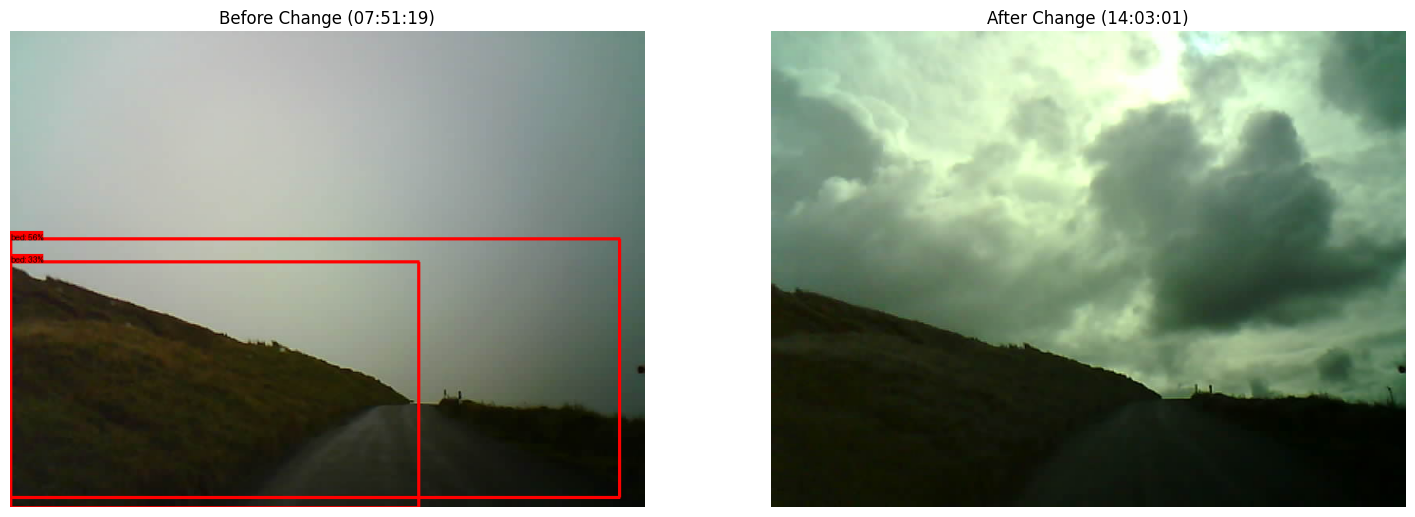


Scene ID: 200
Change detected between 2025-09-08 12:26:26 and 2025-09-12 11:31:40
Summary of change: Disappeared: car.


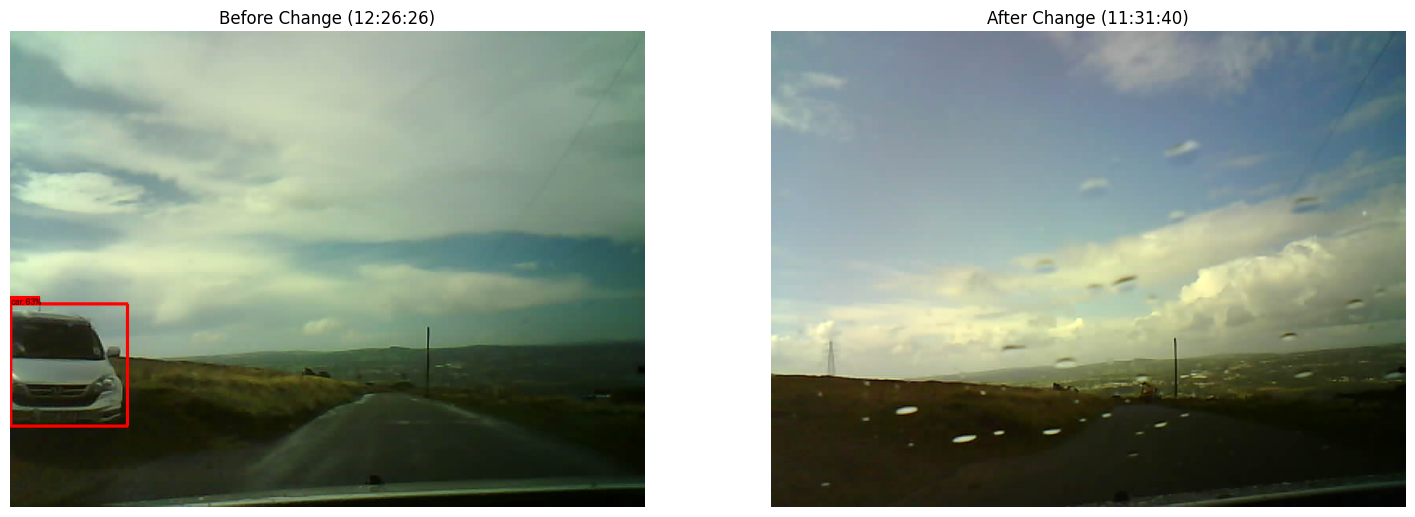


Scene ID: 11
Change detected between 2025-09-03 07:50:29 and 2025-09-05 15:21:49
Summary of change: Disappeared: bed.


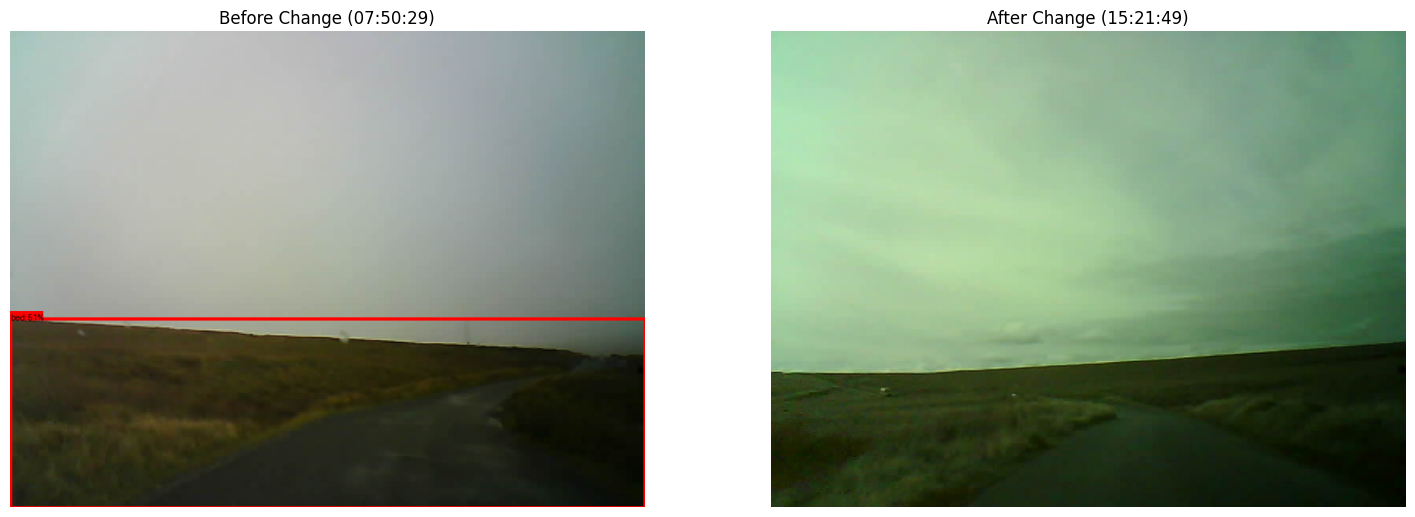

In [35]:
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os

# We need the draw_detections function and category_index again for visualization
# Ensure they are defined or run the cell where they were defined

# Define a function to draw bounding boxes and labels on an image
def draw_detections(image, boxes, classes, scores, category_index, min_score_thresh=0.5):
    """Draws bounding boxes and labels on an image."""
    image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
    draw = ImageDraw.Draw(image_pil)
    im_width, im_height = image_pil.size
    font = ImageFont.load_default() # Use default font

    # Ensure boxes, classes, and scores are numpy arrays
    boxes = np.array(boxes)
    classes = np.array(classes)
    scores = np.array(scores)

    for i in range(len(boxes)):
        if scores[i] > min_score_thresh:
            ymin, xmin, ymax, xmax = boxes[i]
            (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                          ymin * im_height, ymax * im_height)
            draw.line([(left, top), (left, bottom), (right, bottom),
                       (right, top), (left, top)], width=4, fill='red')
            # Ensure class is an integer for category_index lookup
            class_id = int(classes[i])
            class_name = category_index.get(class_id, 'N/A')
            label = f'{class_name}: {int(scores[i]*100)}%'
            # Use ImageDraw.textbbox for calculating text size (more accurate)
            try:
                text_bbox = draw.textbbox((0, 0), label, font=font)
                text_width = text_bbox[2] - text_bbox[0]
                text_height = text_bbox[3] - text_bbox[1]
            except AttributeError:
                # Fallback for older Pillow versions
                text_width, text_height = draw.textsize(label, font=font)


            text_bottom = top
            text_left = left
            margin = np.ceil(0.05 * text_height)
            draw.rectangle([(text_left, text_bottom - text_height - 2 * margin),
                            (text_left + text_width, text_bottom)], fill='red')
            draw.text((text_left + margin, text_bottom - text_height - margin),
                      label, fill='black', font=font)

    return np.array(image_pil)

# We need a category index to map class IDs to class names.
# Assuming category_index is defined in a previous cell and is available
# If not, you would need to define it here or ensure the previous cell is run.
# For now, I will assume it's available based on the previous visualization step.
category_index = {
    1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane',
    6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light',
    11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench',
    16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow',
    22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack',
    28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee',
    35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat',
    40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket',
    44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon',
    51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange',
    56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut',
    61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed',
    67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse',
    75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'microwave', 79: 'oven',
    80: 'toaster', 81: 'sink', 82: 'refrigerator', 84: 'book', 85: 'clock',
    86: 'vase', 87: 'scissors', 88: 'teddy bear', 89: 'hair drier', 90: 'toothbrush'
}


# Select a few random scenes with changes to display
if 'scenes_with_changes' not in locals() and 'scenes_with_changes' not in globals():
    print("Error: scenes_with_changes dictionary not found. Please run the cell that identifies scenes with changes first.")
elif 'df_filtered' not in locals() and 'df_filtered' not in globals():
     print("Error: df_filtered DataFrame not found. Please run the cell that filters the data first.")
elif not scenes_with_changes:
    print("No scenes with detected changes to display.")
else:
    sample_scenes_ids = random.sample(list(scenes_with_changes.keys()), min(3, len(scenes_with_changes))) # Display up to 3 example scenes

    print("Displaying example scenes with detected changes:")

    for scene_id in sample_scenes_ids:
        changes_in_scene = scenes_with_changes[scene_id]

        print(f"\nScene ID: {scene_id}")

        # For simplicity, let's display the first detected change in the scene
        if changes_in_scene:
            first_change = changes_in_scene[0]

            timestamp1 = first_change['timestamp1']
            timestamp2 = first_change['timestamp2']
            classes1 = first_change['classes1']
            classes2 = first_change['classes2']

            # Find the rows in the filtered DataFrame corresponding to these timestamps and scene ID
            img1_row = df_filtered[(df_filtered['scene_id'] == scene_id) & (df_filtered['timestamp_utc'] == timestamp1)].iloc[0]
            img2_row = df_filtered[(df_filtered['scene_id'] == scene_id) & (df_filtered['timestamp_utc'] == timestamp2)].iloc[0]

            image_path1 = img1_row['image_path']
            image_path2 = img2_row['image_path']

            # Get detection results for both images
            detections1 = {
                'detection_boxes': np.array(img1_row['detection_boxes']),
                'detection_classes': np.array(img1_row['detection_classes']),
                'detection_scores': np.array(img1_row['detection_scores'])
            }
            detections2 = {
                'detection_boxes': np.array(img2_row['detection_boxes']),
                'detection_classes': np.array(img2_row['detection_classes']),
                'detection_scores': np.array(img2_row['detection_scores'])
            }


            # Identify the anomalies that appeared or disappeared (for display text)
            appeared = set(classes2) - set(classes1)
            disappeared = set(classes1) - set(classes2)

            appeared_names = [category_index.get(cid, f'Unknown ID: {cid}') for cid in appeared]
            disappeared_names = [category_index.get(cid, f'Unknown ID: {cid}') for cid in disappeared]

            change_summary = ""
            if appeared_names:
                change_summary += f"Appeared: {', '.join(appeared_names)}. "
            if disappeared_names:
                change_summary += f"Disappeared: {', '.join(disappeared_names)}."
            if not change_summary:
                 change_summary = "Classes changed." # Should not happen with current logic

            print(f"Change detected between {timestamp1.strftime('%Y-%m-%d %H:%M:%S')} and {timestamp2.strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"Summary of change: {change_summary}")

            # Display the two images side by side with detections
            try:
                image1 = Image.open(image_path1).convert("RGB")
                image1_np = np.array(image1)
                image_with_detections1 = draw_detections(
                    image1_np,
                    detections1['detection_boxes'],
                    detections1['detection_classes'],
                    detections1['detection_scores'],
                    category_index,
                    min_score_thresh=0.3 # Use the same threshold as before
                )

                image2 = Image.open(image_path2).convert("RGB")
                image2_np = np.array(image2)
                image_with_detections2 = draw_detections(
                    image2_np,
                    detections2['detection_boxes'],
                    detections2['detection_classes'],
                    detections2['detection_scores'],
                    category_index,
                    min_score_thresh=0.3 # Use the same threshold as before
                )

                fig, axes = plt.subplots(1, 2, figsize=(18, 10))
                axes[0].imshow(image_with_detections1)
                axes[0].set_title(f"Before Change ({timestamp1.strftime('%H:%M:%S')})")
                axes[0].axis('off')

                axes[1].imshow(image_with_detections2)
                axes[1].set_title(f"After Change ({timestamp2.strftime('%H:%M:%S')})")
                axes[1].axis('off')

                plt.show()

            except FileNotFoundError:
                print(f"Image file not found for this change: {image_path1} or {image_path2}")
            except Exception as e:
                print(f"Error visualizing change for scene {scene_id}: {e}")
        else:
            print("No change details available for this scene.")